## Example notebook for predictive modeling pipeline

This notebook loads a dataset of Iris leaf characteristics and fits a linear regression model to predict petal witdth. 

The aim if this is to show how with relatively few modifications, we can turn `skeleton_fit_model` into a functional pipeline for regression problems.

Before running this code, you need to import the data. You can do this by running `load_data`.

In [1]:
#import libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split 
from sklearn.inspection import permutation_importance

#import supporting functions used for cleaning
from supporting_functions import check_duplicates, one_hot, add_interactions, filter_features, plot_permutation_importance, prediction_plot

In [2]:
#load data
if not os.path.exists("./data"):
    raise ValueError('You need to import the data first, run load_data.py')
else:
    #df = pd.read_csv('data/iris_data.csv',sep='\t')
    df = pd.read_csv('data/data_iris.csv',sep='\t')

In [3]:
#user-defined target for classification
target_column = 'petal_width_cm'

## Initial exploration

In [4]:
df.head()

,sepal_length_cm,sepal_width_cm,petal_length_cm,petal_width_cm,target,target_names
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


In [5]:
#report nans
df.isnull().mean()

sepal_length_cm    0.0
sepal_width_cm     0.0
petal_length_cm    0.0
petal_width_cm     0.0
target             0.0
target_names       0.0
dtype: float64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sepal_length_cm  150 non-null    float64
 1   sepal_width_cm   150 non-null    float64
 2   petal_length_cm  150 non-null    float64
 3   petal_width_cm   150 non-null    float64
 4   target           150 non-null    int64  
 5   target_names     150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


## Main function for cleaning

In [7]:
def clean_data(df,target_column):
    ### main preprocessing function:

    ## done on train and test set together
    
    #clean up column names
    df.columns = [col.replace(' ', '_') for col in df.columns]
    df.columns = [col.replace('(',  '') for col in df.columns]
    df.columns = [col.replace(')',  '') for col in df.columns]

    #drop column names that we don't need
    df = df.drop(['target', 'target_names'],axis=1)

    #check and report on duplicate data
    df = check_duplicates(df)

    #run train-test split
    #note: X still contains the y-variable in the 'target' column, this is because it 
    #easier to remove rows / apply cleaning steps without having to do it separately 
    #for the target data vector.
    X = df
    X_train, X_test, _, _ = train_test_split(X, df[target_column], random_state=1234) 

    X_train.reset_index(drop=True, inplace=True)
    X_test.reset_index(drop=True, inplace=True)


    ## done separately for train and test
    
    #define / identify columns for range normalization
    columns_to_scale = df.select_dtypes(include='number').columns.drop(target_column) #identify the numeric columns
  
    #range normalization
    scaler = MinMaxScaler()
    scaler.set_output(transform="pandas")

    X_train_scaled = scaler.fit_transform(X_train[columns_to_scale])
    X_test_scaled  = scaler.transform(X_test[columns_to_scale])
    X_train = pd.concat([X_train_scaled, X_train.drop(columns_to_scale,axis=1)], axis=1)
    X_test  = pd.concat([X_test_scaled, X_test.drop(columns_to_scale,axis=1)], axis=1)

    #separate the target
    y_train = X_train.pop(target_column)
    y_test  = X_test.pop(target_column)

    return X_train, X_test, y_train, y_test

##  Main function for Feature engineering

In [8]:
def feature_engineer(df,columns_to_interact,columns_to_dummycode):
    ### main feature engineering function:

    #add interaction terms
    df = add_interactions(df,columns_to_interact)

    #one-hot encode categorical variables
    df = one_hot(df,columns_to_dummycode)

    return df

## Clean the data and make features

In [9]:
X_train, X_test, y_train, y_test = clean_data(df,target_column)

Data has 1 duplicates


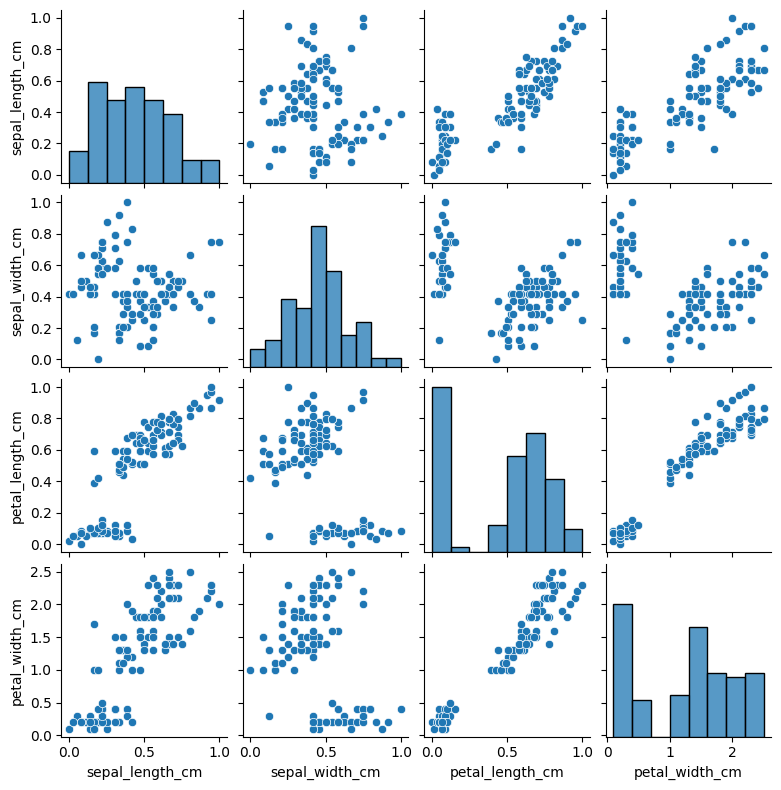

In [10]:
sns.pairplot(pd.concat([X_train, y_train],axis=1), height=2)

## Check the model and select features

In [11]:
#select features with filtering
thresh = 0.95 #remove features that correlate above this threshold
X_train, X_test, discarded_features = filter_features(X_train,X_test,thresh)

No features dropped based on correlation.


<Axes: >

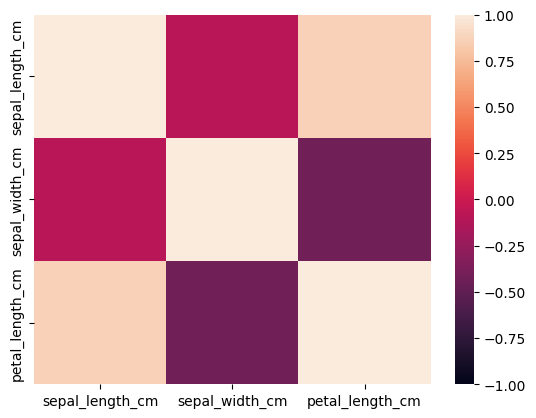

In [12]:
#plot correlation between regressors
sns.heatmap(X_train.corr(),vmin=-1,vmax=1)

## Fit the model

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score


# Initialize the LinearRegression model
mdl = ElasticNet()

# Define the parameter grid (in this case, there are no hyperparameters for LinearRegression, so we use an empty grid)
param_grid = {
              'alpha': [0.01, 0.1, 1, 10],  # Regularization strength
              'l1_ratio': [0.1, 0.5, 0.9]
             }

#define cross-validation scheme
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1234)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=mdl, 
                           param_grid=param_grid, 
                           cv=5, 
                           scoring='neg_mean_squared_error')

# Fit the model
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test)

## Evaluate the model

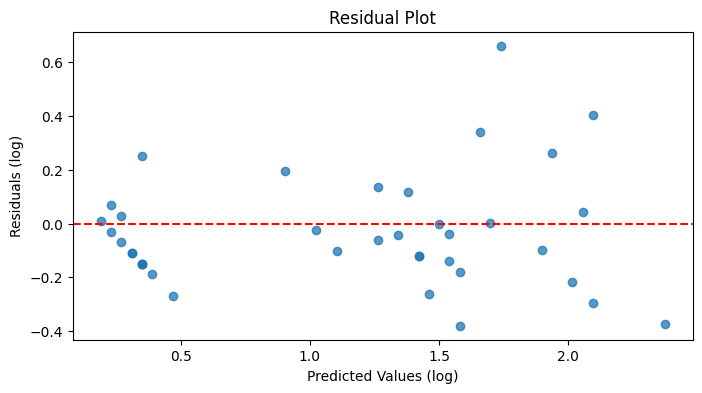

Best Parameters: {'alpha': 0.01, 'l1_ratio': 0.9}
Best Cross-Validation Score: 0.04352334538798123
Test Set Mean Squared Error: 0.04548010205550679
Test Set R^2 Score: 0.9128631947668084


In [16]:
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(8, 4))
plt.scatter(y_pred, residuals, alpha=0.75)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values (log)')
plt.ylabel('Residuals (log)')
plt.title('Residual Plot')
plt.show()

# Print the best parameters and the corresponding score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", -grid_search.best_score_)

# Evaluate the model on the test set
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Test Set Mean Squared Error:", mse)
print("Test Set R^2 Score:", r2)
plt.show()

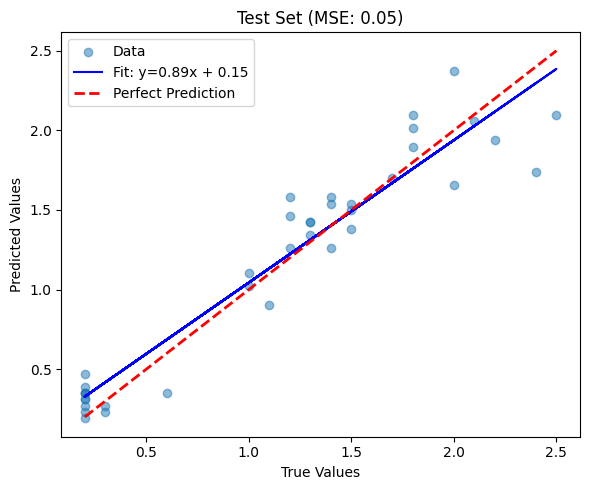

In [17]:
#plot predicted versus true test set values
prediction_plot(y_test,y_pred)

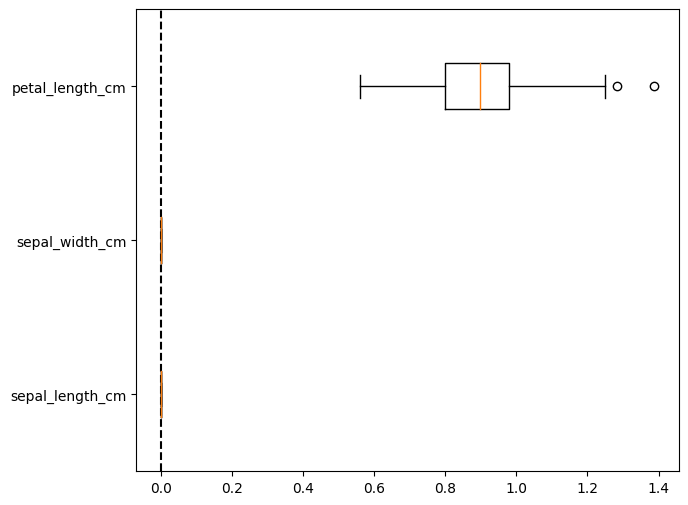

In [15]:
#compute and plot feature importance
feature_importance = permutation_importance(grid_search, X_test,y_test,n_repeats=100,random_state=1234)
plot_permutation_importance(feature_importance,X_test.columns)